* Name: `dissipation-theory--Study-25.ipynb`
* Author: John A. Marohn
* Date: 2024-10-11
* Continued from: `dissipation-theory--Study-23.ipynb`
* Continued to: ---
* Summary: Extend the simulations and plots in `Study 23`.

For a chosen set of cantilever and sample parameters, plot versus charge density $\rho$ the
- low-frequency BLDS frequency shift $|\Delta f_{\mathrm{BLDS}}(0)|$ and
- cantilever friction $\gamma_{\mathrm{\perp}}$.

Plot these quantities versus, respectively, the unitless parameters
- $(h/\lambda_{\mathrm{D}})^2$, with $h$ the tip-sample separation and $\lambda_{\mathrm{D}}$ the Debye length, and
- $\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$, with $\omega_0 = \sigma/\epsilon_0$, $\sigma$ the conductivity, $\epsilon_{\mathrm{s}}^{\prime}$ the real part of the dielectric constant, and $\omega_{\mathrm{c}}$ the cantilever resonance frequency.

Compare Marohn's numerical calcualtions to Loring's low-density and high-density approximations for $|\Delta f_{\mathrm{BLDS}}(0)|$.

# Preliminaries

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation2 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit, theta1norm_jit
from dissipationtheory.dissipation  import blds_perpendicular_jit, gamma_perpendicular_jit
from dissipationtheory.data import BLDSData
from dissipationtheory.capacitance import CsphereOverSemi

In [1]:
THIS = 'dissipation-theory--Study-25--'
fig = {}

# Simulate friction and the BLDS spectrum as charge density increases

Assume the density increases while the charge mobility stays constant.

Cantilever with "new" tip might have a radius of $R = 35 \: \mathrm{nm}$.  BLDS measurements might be taken at $d = 200 \: \mathrm{nm}$.  Friction ringdown measurements can get as close as $d = 38 \: \mathrm{nm}$.  

In [5]:
cantilever_jit = CantileverModelJit(
    f_c = 75e3, 
    V_ts = 1.0,
    R = 35e-9,
    d = 38e-9
)

Pick a thick sample, $h_{\mathrm{s}} = 500 \: \mathrm{nm}$.  Guess a dielectric constant on the low side for a perovskite, $\epsilon_{\mathrm{r}} = 20$, to get a larger BLDS signal.  A reasonable guess for a perovskite dielectric constant is 20 to 100 (real part); pick -2 for the imaginary part, an arbitrary choice.  We are going to vary the conductivity and charge density.

Assume the sample is backed by a metal, which we mimic by setting $\epsilon_{\mathrm{d}} = 10^{6}$.

In [6]:
sample_jit = SampleModel1Jit(
    cantilever = cantilever_jit,
    h_s = 500e-9,
    epsilon_s = complex(20, -0.2),
    sigma = 1e-5,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 300e-9
)

Print out a report of sample properties.

In [7]:
sample_jit.print()

cantilever
   cantilever freq =  75000.0 Hz
                   =  471238.89803846896 rad/s
tip-sample voltage =  1.0 V
            radius =  3.5e-08 m
            height =  3.8e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  5e-07 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


Vary the conductivity, but keep the mobility fixed, which means we must also vary charge density.

In [8]:
N_omega = 50
N_sigma = 50

In [9]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

Relative to `Study 23`, increase the upper limit of `sigma` by a few orders of magnitude.

In [10]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a *fixed* mobility of $\mu = 10^{-8} \: \mathrm{m}^2 / \mathrm{V s}$.  This is an ionic mobility. 

In [11]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)')  # <=== adjust this

print("mu = {:e} cm^2(V s)".format(
    mu.to('cm^2/(V s)').magnitude))

mu = 1.000000e-04 cm^2(V s)


As we vary $\sigma$, we also need to vary $\rho$.

In [12]:
rho = (sigma / (qe * mu)).to('1/m^3')

print("rho range: {:e} to {:e} 1/m^3".format(
    min(rho).to('1/m^3').magnitude,
    max(rho).to('1/m^3').magnitude))

rho range: 6.241509e+17 to 6.241509e+26 1/m^3


Get ready to run the simulations.

In [13]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Step the charge density and conductivity and compute a friction and BLDS spectrum at each step.  When you vary the charge density, you also vary the Debye length.  Keep track of the Debye length as you step the charge density.

In [14]:
# remember
sigma0 = sample_jit.sigma
rho0 =  sample_jit.rho

# set
for rho_, sigma_ in zip(rho, sigma):
    
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')

    sample_jit.rho = rho_.to('1/m^3').magnitude
    sample_jit.sigma = sigma_.to('S/m').magnitude
    
    gamma = gamma_perpendicular_jit(theta1norm_jit, sample_jit).to('pN s/m')
    
    for index, omega_ in enumerate(omega_m):
        
        freq[index] = blds_perpendicular_jit(
            theta1norm_jit,
            sample_jit,
            omega_).to('Hz')
    
    data['01'][str(sigma_)] = {
        'omega_m': omega_m,
        'f_BLDS': freq, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sample_jit.sigma, 'S/m'),
        'd': ureg.Quantity(sample_jit.cantilever.d, 'm'),
        'rho': ureg.Quantity(sample_jit.rho, '1/m^3'),
        'LD': ureg.Quantity(sample_jit.LD, 'm'),
        'omega_c': ureg.Quantity(sample_jit.cantilever.omega_c, 'Hz'),
        'omega_0': (ureg.Quantity(sample_jit.sigma, 'S/m')/epsilon0).to('Hz')}

# reset
sample_jit.rho = rho0
sample_jit.sigma = sigma0

Helper function to plot the BLDS spectra.

In [15]:
def plotBLDS(data, sample_jit):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].to('Hz').magnitude),
                '-',
                color=color_list[index])

    # if you want the separation and radius on the plot title
    if 0: 
    
        lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(
            sample_jit.cantilever.d/1e-9,
            sample_jit.cantilever.R/1e-9)
        
        plt.title(lbl, fontsize=9)

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot the BLDS spectra.

Actually plot a subset of the BLDS spectra.

In [16]:
data['01-short'] = {}
for key in list(data['01'].keys())[::2]:  # gotta list, MF'a
    data['01-short'][key] = data['01'][key]

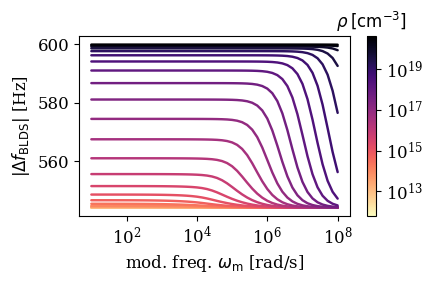

In [17]:
fig['01'] = plotBLDS(data['01-short'], sample_jit)

Helper function to plot the (a) low-frequency limit of the BLDS frequency shift and (b) dissipation versus charge density.  This function simply reproduces the plot in `Study-23`.

In [18]:
def plotgammaA(data, sample_jit):

    # gather up friction data
    
    rho = np.zeros(len(data))
    gamma = np.zeros(len(data))
    blds0 = np.zeros(len(data))
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        gamma[index] = data[key]['gamma'][0].to('pN s/m').magnitude
        blds0[index] = np.abs(data[key]['f_BLDS'][0].to('Hz').magnitude)
        
    # now make a plot
    
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))

    with plt.style.context('seaborn-v0_8'):
        ax[0].semilogx(rho, blds0, '-')
        ax[1].semilogx(rho, gamma, '-')
        
    ax[0].set_ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[0].set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax[1].set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

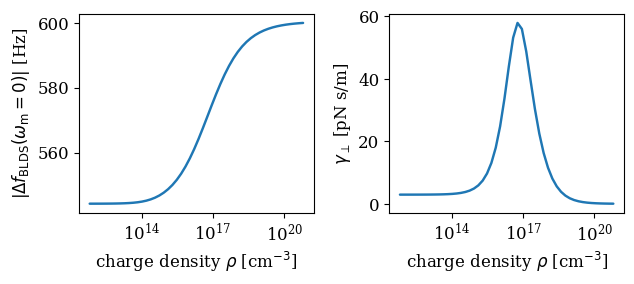

In [19]:
fig['02'] = plotgammaA(data['01'], sample_jit)

# Loring's approximations for the BLDS spectrum

Code up **Loring's approximations** for the low-frequency and high-frequency limits of the BLDS spectrum.  Build up this approximation in a number of steps.

The function below returns the *absolute value* of the following prefactor, with units. 

\begin{equation}
-\frac{f_{\mathrm{c}} c_0^2 V_0^2}{16 \pi \epsilon_0 k_{\mathrm{c}} h^3}
\end{equation}

In the above equation $f_{\mathrm{c}}$ is the cantilever frequency, $c_0$ is the tip-sample capacitance, $V_0$ is the tip-sample voltage, $\epsilon_0$ is the free-space permittivity, $k_{\mathrm{c}}$ is the cantilever spring constant, and $h$ is the tip-sample separation.

In [20]:
def BLDSpre(sample):

    fc = ureg.Quantity(sample.cantilever.f_c, 'Hz')
    c0 = CsphereOverSemi(index=0, 
        height=ureg.Quantity(sample.cantilever.d,'m') * np.ones(1), 
        radius=ureg.Quantity(sample.cantilever.R,'m'),
        epsilon=sample.epsilon_d.real)
    V0 = ureg.Quantity(sample_jit.cantilever.V_ts, 'V')
    kc = ureg.Quantity(2.8, 'N/m')
    h = ureg.Quantity(sample.cantilever.d,'m')

    pre = ((fc * c0**2 * V0**2)/(16 * np.pi * epsilon0 * kc * h**3)).to('Hz')

    return pre

The above function returns a number with the right units.  Hurray!

In [21]:
BLDSpre(sample_jit)

Magnitude,[29.052807269111536]
Units,hertz


Loring's expansions for the BLDS frequency shift are carried out in terms of a unitless parameter

\begin{equation}
x \equiv \left( \frac{h}{\lambda_{\mathrm{D}}} \right)^2
\end{equation}

with $h$ the tip-sample separation and $\lambda_{\mathrm{D}}$ the Debye length.  Given an array of $x$-values, return an array of values for the low-density (i.e., small $x$) and high-density (i.e., large $x$) limiting values of the absolute value of the BLDS frequency shift.

In [22]:
def BLDSlimits(sample, x):

    pre = BLDSpre(sample)
    er = sample.epsilon_s.real
    a = 0.25 * (er - 1)/(er + 1)
    ones = np.ones(len(x))
    
    return [pre * a * ones, pre * 0.25 * ones]

The two returned arrays have units.

In [23]:
BLDSlimits(sample_jit, np.logspace(-3, 2, 5))

[<Quantity([6.57146831 6.57146831 6.57146831 6.57146831 6.57146831], 'hertz')>,
 <Quantity([7.26320182 7.26320182 7.26320182 7.26320182 7.26320182], 'hertz')>]

Now make a function to return Loring's low-density approximation for the BLDS frequency shift.  The dependent variable here is $x = (h/\lambda_{\mathrm{D}})^2$, as above.  The approximation is of the form $c_1 + c_2 x$ with $c_1$ and $c_2$ constants.  The approximation increases without bound at large $x$.  Only return values where the approximate BLDS frequency shift is less than the high-frequency limit.  Return a copy of the $x$ array where this is true; this truncated $x$ array will be handy for plotting.

In [24]:
def BLDSapprox(sample, x):

    pre = BLDSpre(sample)
    BLDS_low, BLDS_high = BLDSlimits(sample, x)
    
    er = sample.epsilon_s.real
    a = 0.25 * (er - 1)/(er + 1)
    b = 0.50 * er / (er + 1)**2

    BLDS_approx = pre * (a + b * x)
    mask = BLDS_approx.to('Hz').magnitude <= BLDS_high.to('Hz').magnitude
    
    return [x[mask], BLDS_approx[mask]]

Create a plot of the absolute value of the zero-frequency limit of the BLDS frequency versus the unitless parameter $x$, showing the 

- low-frequency limit (dashed black line)
- high-frequency limit (dash-dotted black line), and
- Loring's low-density approximation (blue line).

In [31]:
def plotBLDSapprox(sample):

    x_temp = np.logspace(-3, 2, 40)
    BLDS_low, BLDS_high = BLDSlimits(sample, x_temp)
    x_sub, BLDS_sub = BLDSapprox(sample, x_temp)
    
    fig = plt.figure(figsize=(3.5, 2.5))
    
    plt.semilogx(x_temp, BLDS_low.to('Hz').magnitude, 'k--')
    plt.semilogx(x_temp, BLDS_high.to('Hz').magnitude, 'k-.')
    plt.semilogx(x_sub, BLDS_sub.to('Hz').magnitude,'-')
    
    plt.xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    plt.ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')

    plt.tight_layout()
    plt.show()
    
    return fig

We can see that the linear correction term starts to rise around $x \sim 1$, as expected.

<div class="alert alert-block alert-success">
As the unitless parameter $x = (h/\lambda_{\mathrm{D}})^2$ is increased, the BLDS frequency shift $|\Delta f_{\mathrm{BLDS}}(0)|$ starts to increase when $x \leq 1$  as Loring's low-density expansion indicates. 
</div>

<div class="alert alert-block alert-danger">
Looking at the plots above and below, the $|\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)|$ predicted by Marohn's numerical calculations is in poor agreement with Loring's approximations.
</div>

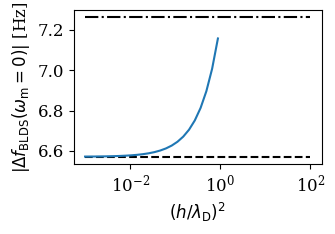

In [32]:
fig['03'] = plotBLDSapprox(sample_jit)

Plot the calculated friction and low-frequency BLDS frequency shift another way.

* (left) **Zero-frequency limit of the BLDS frequency shift**.  Add a second x-axis, $(h/\lambda_{\mathrm{D}})^2$, with $h$ the probe height and $\lambda_{\mathrm{D}}$ the Debye length.  The unitless squared ratio  $(h/\lambda_{\mathrm{D}})^2$ is linearly proportional to the charge density $\rho$.  Adding a second x-axis is tricky.  Read [here](https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis) and [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.secondary_xaxis.html).

* (right) **Perpendicular friction**.  According to Loring and Marohn's analysis, we should see maximum friction when the frequency  $\omega_0 = \sigma/\epsilon_0$ equals the cantilever frequency $\omega_{\mathrm{c}}$.  Varying $\epsilon_{\mathrm{s}}^{\prime}$ (simulations not shown), I find empirically that friction peaks instead when $\omega_0 = \sigma/\epsilon_0$ equals $\epsilon_{\mathrm{s}}^{\prime}  \omega_{\mathrm{c}}$.  Therefore add a second x-axis, $\omega_0/(\epsilon_{\mathrm{s}}^{\prime}  \omega_{\mathrm{c}})$.

In [27]:
def plotgammaB(data, sample):

    # Loop over the data and gather up the charge density, Debye length, cantilever height,
    # friction and BLDS frequency shift at the lowest modulation frequency (approximating
    # the zero-frequency limit)
    
    rho = np.zeros(len(data))
    LD = np.zeros(len(data))
    d = np.zeros(len(data))
    gamma = np.zeros(len(data))
    blds0 = np.zeros(len(data))
    omega_0 = np.zeros(len(data))
    omega_c = np.zeros(len(data))
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        LD[index] = data[key]['LD'].to('m').magnitude
        d[index] = data[key]['d'].to('m').magnitude
        gamma[index] = data[key]['gamma'][0].to('pN s/m').magnitude
        blds0[index] = np.abs(data[key]['f_BLDS'][0].to('Hz').magnitude)
        omega_0[index] = data[key]['omega_0'].to('Hz').magnitude
        omega_c[index] = data[key]['omega_c'].to('Hz').magnitude
    
    # (Left hand plot) 
    # Make the x-axis the unitless ratio of the height to Debye length squared,
    # which is proportional to charge density.

    xL = (d/LD)**2
    rho0L = (rho/xL)[0]

    # Define functions to convert from xL to rho and back again
    
    def fwdL(xL):
        return xL*rho0L

    def revL(rho):
        return rho/rho0L

    # (Right hand plot)
    # Make the x-axis the unitless ratio of omega_0 to omega_c, which
    # is proportional to conductivity and therefore charge density

    xR = omega_0/(sample.epsilon_s.real * omega_c)
    rho0R = (rho/xR)[0]
    
    # Define functions to convert from xR to rho and back again

    def fwdR(xR):
        return xR*rho0R

    def revR(rho):
        return rho/rho0R
    
    # Now make the nice plot
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))
    
    ax2L = ax[0].secondary_xaxis("top", functions=(fwdL,revL))
    ax2R = ax[1].secondary_xaxis("top", functions=(fwdR,revR))
    
    with plt.style.context('seaborn-v0_8'):
        ax[0].semilogx(xL, blds0, '-')
        ax[1].semilogx(xR, gamma, '-')
        ax[0].grid()
        ax[1].grid()
        
    ax[0].set_ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[0].set_xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    ax[1].set_xlabel(r'$\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$') 
    ax2L.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax2R.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

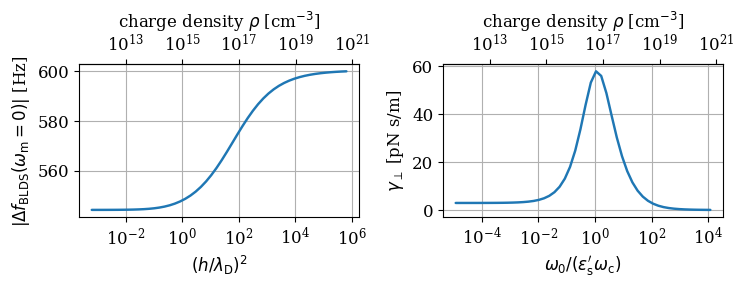

In [28]:
fig['04'] = plotgammaB(data['01'], sample_jit)

<div class="alert alert-block alert-success">
As charge density $\rho$ is increased, Marohn's numerically computed BLDS frequency shift $|\Delta f_{\mathrm{BLDS}}(0)|$ increases when $(h/\lambda_{\mathrm{D}})^2 \geq 1$ as Loring's low-density expansion indicates. 
</div>

<div class="alert alert-block alert-danger">
Marohn's numerical estimate of $|\Delta f_{\mathrm{BLDS}}(0)|$ is approximately 100-fold larger than that predicted by Loring's low-density expansion. 
</div>

<div class="alert alert-block alert-warning">
As charge denstiy $\rho$ is increased, the perpendicular friction $\gamma_{\perp}$ increases and reaches a maximum when $\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}}) = 1$, not when $\omega_0/\omega_{\mathrm{c}} = 1$.
</div>

# Summarize the properties

Cantilever

- $f_c = 75 \: \mathrm{kHz}$,
- $k_c = 2.8 \: \mathrm{N/m}$,
- $R = 35 \: \mathrm{nm}$,
- $h = 38 \: \mathrm{nm}$, and
- $V_{\mathrm{ts}} = 1 \: \mathrm{V}$.

Sample
- $h_{\mathrm{s}} = 500 \: \mathrm{nm}$,
- $\epsilon_{\mathrm{s}} = 20 - 0.2 \, j$,
- $\mu = 10^{-8} \: \mathrm{m}^2 / \mathrm{V s}$,
- $\epsilon_{\mathrm{d}} = 10^{6}$ fixed; and
- $\rho$ and $\sigma = e \mu \rho$ varied.

In [29]:
sample_jit.print()

cantilever
   cantilever freq =  75000.0 Hz
                   =  471238.89803846896 rad/s
tip-sample voltage =  1.0 V
            radius =  3.5e-08 m
            height =  3.8e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  5e-07 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


# Save all figures

In [33]:
if 1:
    for num in fig.keys():
        figname = THIS + "Fig-" + num
        fig[num].savefig(figname + '.png', dpi=300)
        fig[num].savefig(figname + '.pdf')